# Packages

In [1]:
import pandas as pd
import duckdb as db
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

In [2]:
import os
print(os.getcwd())

/Users/gaberiedel/baseball_projects/SMT_2025/backend/analysis_code


# Steal Plays

In [ ]:
with db.connect("../database/smt_2025.db") as con:
    players_on_first = con.sql("""SELECT DISTINCT first_baserunner AS player_name FROM game_info""").df()
    plays_on_first = con.sql("""SELECT COUNT(*) count_on_first, first_baserunner AS player_name FROM game_info 
                                WHERE first_baserunner != 'NA' AND second_baserunner = 'NA' 
                                    AND third_baserunner = 'NA'
                                GROUP BY first_baserunner
                                ORDER BY COUNT(*) DESC""").df()
    
    steal_count = con.sql("""WITH pitches AS (SELECT * FROM 
                            (SELECT *, 
                            LEAD(event_code) OVER (PARTITION BY game_str, play_per_game ORDER BY timestamp, event_code) AS next_event
                            FROM game_events) subquery
                            WHERE event_code = 1 AND next_event = 2
                            ORDER BY game_str, play_per_game),
                          
                          runner_info AS (SELECT * FROM 
                            (SELECT *, LEAD(first_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_first_base,
                                    LEAD(second_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_second_base,
                                    LEAD(third_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_third_base
                            FROM game_info) subquery
                            WHERE first_baserunner != 'NA' AND next_second_base != 'NA' AND second_baserunner = 'NA' AND third_baserunner = 'NA'
                              AND next_first_base = 'NA' AND next_third_base = 'NA'
                            ORDER BY game_str, play_per_game  )
                          
                          SELECT COUNT(*) stolen_bases, next_second_base AS player_name FROM
                            (SELECT pi.game_str, play_id, pi.play_per_game, player_position, event_code, next_event, pi.home_team, first_baserunner, second_baserunner, next_second_base FROM pitches pi
                            INNER JOIN runner_info ri
                            ON pi.game_str = ri.game_str AND pi.play_per_game = ri.play_per_game) subquery
                          GROUP BY next_second_base
                          ORDER BY COUNT(*) DESC""").df()
  
    steal_plays = con.sql("""WITH pitches AS (SELECT * FROM 
                            (SELECT *, 
                            LEAD(event_code) OVER (PARTITION BY game_str, play_per_game ORDER BY timestamp, event_code) AS next_event
                            FROM game_events) subquery
                            WHERE event_code = 1 AND next_event = 2
                            ORDER BY game_str, play_per_game),
                          
                          runner_info AS (SELECT * FROM 
                            (SELECT *, LEAD(first_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_first_base,
                                    LEAD(second_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_second_base,
                                    LEAD(third_baserunner) OVER (PARTITION BY game_str, top_bottom_inning ORDER BY play_per_game) AS next_third_base
                            FROM game_info) subquery
                            WHERE first_baserunner != 'NA' AND next_second_base != 'NA' AND second_baserunner = 'NA' AND third_baserunner = 'NA'
                              AND next_first_base = 'NA' AND next_third_base = 'NA'
                            ORDER BY game_str, play_per_game  )
                          
                          SELECT pi.game_str, play_id, pi.play_per_game, player_position, event_code, next_event, pi.home_team, first_baserunner, second_baserunner, next_second_base FROM pitches pi
                            INNER JOIN runner_info ri
                            ON pi.game_str = ri.game_str AND pi.play_per_game = ri.play_per_game""").df()

steal_plays.to_csv("steal_plays.csv")

In [ ]:
steal_plays

,game_str,play_id,play_per_game,player_position,event_code,next_event,home_team,first_baserunner,second_baserunner,next_second_base
0,y2_d068_RDO_RZQ,77,77,1,1,2,RZQ,RDO-1507,NA,RDO-1507
1,y2_d069_RDO_RZQ,250,250,1,1,2,RZQ,RDO-1818,NA,RDO-1818
2,y2_d070_RDO_RZQ,198,198,1,1,2,RZQ,RZQ-0310,NA,RZQ-0310
3,y2_d071_DYE_YJD,323,323,1,1,2,YJD,DYE-0331,NA,DYE-0331
4,y2_d071_XFE_RZQ,146,146,1,1,2,RZQ,RZQ-0310,NA,RZQ-0310
...,...,...,...,...,...,...,...,...,...,...
280,y2_d063_KIR_RZQ,307,307,1,1,2,RZQ,KIR-1477,NA,KIR-1477
281,y2_d065_HKR_RZQ,54,54,1,1,2,RZQ,RZQ-0143,NA,RZQ-0143
282,y2_d057.5_IAK_RZQ,61,61,1,1,2,RZQ,RZQ-0310,NA,RZQ-0310
283,y2_d065_HKR_RZQ,177,177,1,1,2,RZQ,RZQ-0143,NA,RZQ-0143


In [4]:
df_runners = pd.merge(players_on_first, plays_on_first, on = "player_name", how = "left")
df_runners

,player_name,count_on_first
0,QEA-0027,101.0
1,QEA-0071,60.0
2,ACN-1147,5.0
3,APZ-1755,11.0
4,APZ-1778,23.0
...,...,...
893,VMN-1362,7.0
894,WZR-1570,12.0
895,WZR-1875,19.0
896,WZR-2046,NaN


In [5]:
df_runners = pd.merge(players_on_first, plays_on_first, on = "player_name", how = "left")
df_thieves = pd.merge(df_runners, steal_plays, on="player_name", how="left").fillna(0).sort_values(by="stolen_bases", ascending=False)
df_thieves["steal_score"] = (df_thieves["stolen_bases"]/df_thieves["count_on_first"] * np.log(df_thieves["stolen_bases"])).fillna(0)
df_thieves.sort_values(by="steal_score", ascending=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log


,player_name,count_on_first,stolen_bases,steal_score
161,BEJ-1854,3.0,2.0,0.462098
367,NSO-1891,8.0,3.0,0.411980
574,GHD-1403,4.0,2.0,0.346574
260,WZR-1942,4.0,2.0,0.346574
619,OWH-1692,15.0,3.0,0.219722
...,...,...,...,...
587,YJD-0308,3.0,0.0,0.000000
588,NYA-2033,26.0,0.0,0.000000
589,POW-2095,38.0,0.0,0.000000
590,POW-2317,0.0,0.0,0.000000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 30'. Pick better value with 'binwidth'.


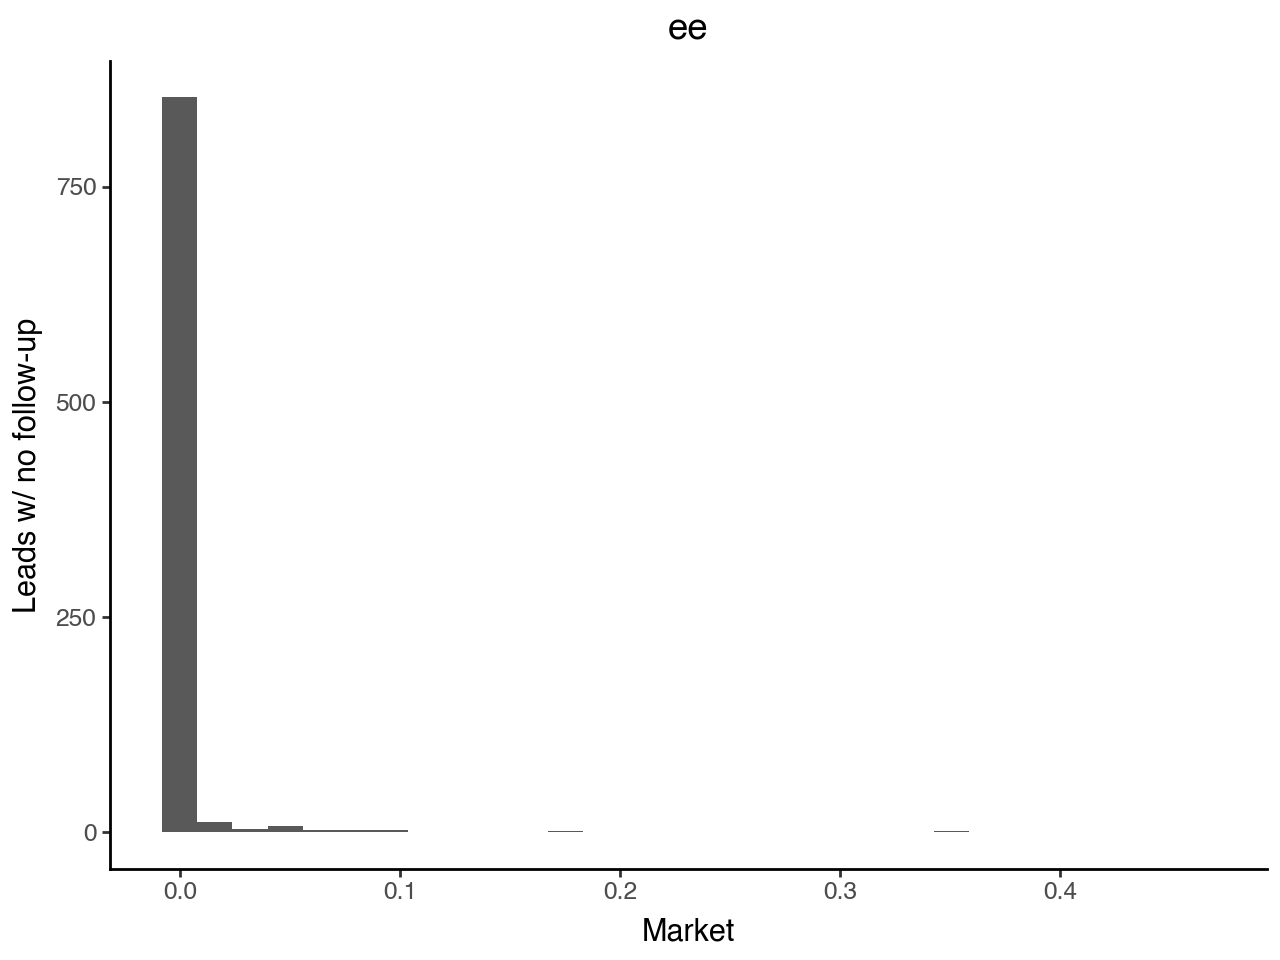

In [6]:
ggplot(df_thieves, aes(x='steal_score')) \
+ geom_histogram() \
+ labs(title = "ee",
       x="Market",
       y="Leads w/ no follow-up") \
+ theme_classic()

# Pickoff plays

In [60]:
with db.connect("../database/smt_2025.db") as con:
    df_pickoff_plays = con.sql("""
                               WITH first_base_player_pos AS (SELECT game_str, play_id, timestamp, player_position AS runner, field_x, field_y
                                FROM(
                                    SELECT *, DENSE_RANK() OVER (PARTITION BY game_str, play_id ORDER BY timestamp) as time_order
                                    FROM player_pos 
                                    WHERE player_position = 11
                                    ORDER BY game_str, play_id, timestamp) sub1
                                    WHERE time_order = 1)
                               SELECT * 
                               FROM game_events ge
                               LEFT JOIN game_info gi 
                               ON ge.game_str = gi.game_str AND ge.play_per_game = gi.play_per_game
                               INNER JOIN first_base_player_pos fb
                               ON ge.game_str = fb.game_str AND ge.play_id = fb.play_id
                               WHERE player_position = 1 AND event_code = 6 
                                AND second_baserunner = 'NA' AND third_baserunner = 'NA' """).df()

df_pickoff_plays

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,year,...,second_baserunner,third_baserunner,year_1,day_1,game_str_2,play_id_1,timestamp_1,runner,field_x,field_y
0,y2_d058_POW_YJD,24,8,24,686409,1,6,YJD,POW,year_2,...,NA,NA,year_2,day_058,y2_d058_POW_YJD,24,683409,11,55.4958,72.6300
1,y2_d058_POW_YJD,46,12,46,1360159,1,6,YJD,POW,year_2,...,NA,NA,year_2,day_058,y2_d058_POW_YJD,46,1357159,11,57.3279,73.6011
2,y2_d058_POW_YJD,222,57,222,7435009,1,6,YJD,POW,year_2,...,NA,NA,year_2,day_058,y2_d058_POW_YJD,222,7432009,11,56.0919,71.5350
3,y2_d059_POW_YJD,3,18,69,1943873,1,6,YJD,POW,year_2,...,NA,NA,year_2,day_059,y2_d059_POW_YJD,3,1940873,11,55.8738,73.8507
4,y2_d059_POW_YJD,4,18,70,1964773,1,6,YJD,POW,year_2,...,NA,NA,year_2,day_059,y2_d059_POW_YJD,4,1961773,11,55.6536,73.7916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,y2_d052_PTB_YJD,50,9,50,1397001,1,6,YJD,PTB,year_2,...,NA,NA,year_2,day_052,y2_d052_PTB_YJD,50,1394001,11,56.6988,72.2196
1201,y2_d046_IHI_YJD,142,36,142,4104030,1,6,YJD,IHI,year_2,...,NA,NA,year_2,day_046,y2_d046_IHI_YJD,142,4101030,11,55.2537,75.5781
1202,y2_d057.5_IAK_RZQ,175,50,175,5655606,1,6,RZQ,IAK,year_2,...,NA,NA,year_2,day_057.5,y2_d057.5_IAK_RZQ,175,5652606,11,57.5721,72.6723
1203,y2_d046_IHI_YJD,57,18,57,1780330,1,6,YJD,IHI,year_2,...,NA,NA,year_2,day_046,y2_d046_IHI_YJD,57,1777330,11,55.2711,73.3131


In [61]:
df_pickoff_plays["lead_distance"] = np.sqrt(pow(df_pickoff_plays["field_x"]-63.63, 2) + pow(df_pickoff_plays["field_y"]-63.63, 2)) - 1.25
df_pickoff_plays["lead_distance"].mean()

np.float64(10.028087972768745)

In [64]:
df_pickoff_plays


,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,year,...,third_baserunner,year_1,day_1,game_str_2,play_id_1,timestamp_1,runner,field_x,field_y,lead_distance
0,y2_d058_POW_YJD,24,8,24,686409,1,6,YJD,POW,year_2,...,NA,year_2,day_058,y2_d058_POW_YJD,24,683409,11,55.4958,72.6300,10.881167
1,y2_d058_POW_YJD,46,12,46,1360159,1,6,YJD,POW,year_2,...,NA,year_2,day_058,y2_d058_POW_YJD,46,1357159,11,57.3279,73.6011,10.545732
2,y2_d058_POW_YJD,222,57,222,7435009,1,6,YJD,POW,year_2,...,NA,year_2,day_058,y2_d058_POW_YJD,222,7432009,11,56.0919,71.5350,9.673002
3,y2_d059_POW_YJD,3,18,69,1943873,1,6,YJD,POW,year_2,...,NA,year_2,day_059,y2_d059_POW_YJD,3,1940873,11,55.8738,73.8507,11.580485
4,y2_d059_POW_YJD,4,18,70,1964773,1,6,YJD,POW,year_2,...,NA,year_2,day_059,y2_d059_POW_YJD,4,1961773,11,55.6536,73.7916,11.668246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,y2_d052_PTB_YJD,50,9,50,1397001,1,6,YJD,PTB,year_2,...,NA,year_2,day_052,y2_d052_PTB_YJD,50,1394001,11,56.6988,72.2196,9.787335
1201,y2_d046_IHI_YJD,142,36,142,4104030,1,6,YJD,IHI,year_2,...,NA,year_2,day_046,y2_d046_IHI_YJD,142,4101030,11,55.2537,75.5781,13.341761
1202,y2_d057.5_IAK_RZQ,175,50,175,5655606,1,6,RZQ,IAK,year_2,...,NA,year_2,day_057.5,y2_d057.5_IAK_RZQ,175,5652606,11,57.5721,72.6723,9.633995
1203,y2_d046_IHI_YJD,57,18,57,1780330,1,6,YJD,IHI,year_2,...,NA,year_2,day_046,y2_d046_IHI_YJD,57,1777330,11,55.2711,73.3131,11.541936


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 135'. Pick better value with 'binwidth'.


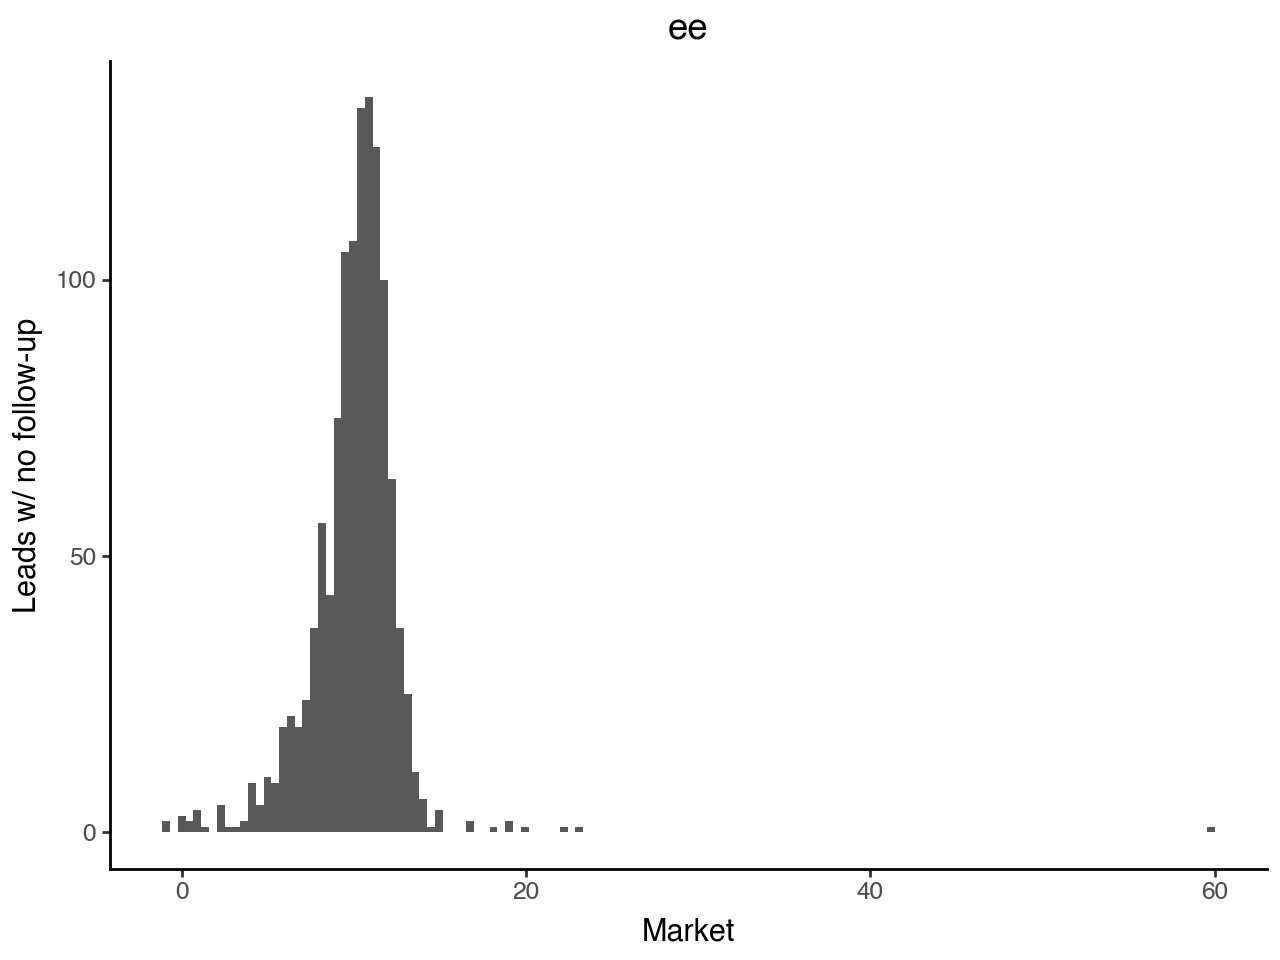

In [34]:
ggplot(df_pickoff_plays, aes(x='lead_distance')) \
+ geom_histogram() \
+ labs(title = "ee",
       x="Market",
       y="Leads w/ no follow-up") \
+ theme_classic()

In [65]:
df_pickoff_plays["is_home"] = np.where(df_pickoff_plays['top_bottom_inning'] == "top", 1, 0)
df_pickoff_plays

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,home_team,away_team,year,...,year_1,day_1,game_str_2,play_id_1,timestamp_1,runner,field_x,field_y,lead_distance,is_home
0,y2_d058_POW_YJD,24,8,24,686409,1,6,YJD,POW,year_2,...,year_2,day_058,y2_d058_POW_YJD,24,683409,11,55.4958,72.6300,10.881167,0
1,y2_d058_POW_YJD,46,12,46,1360159,1,6,YJD,POW,year_2,...,year_2,day_058,y2_d058_POW_YJD,46,1357159,11,57.3279,73.6011,10.545732,1
2,y2_d058_POW_YJD,222,57,222,7435009,1,6,YJD,POW,year_2,...,year_2,day_058,y2_d058_POW_YJD,222,7432009,11,56.0919,71.5350,9.673002,0
3,y2_d059_POW_YJD,3,18,69,1943873,1,6,YJD,POW,year_2,...,year_2,day_059,y2_d059_POW_YJD,3,1940873,11,55.8738,73.8507,11.580485,0
4,y2_d059_POW_YJD,4,18,70,1964773,1,6,YJD,POW,year_2,...,year_2,day_059,y2_d059_POW_YJD,4,1961773,11,55.6536,73.7916,11.668246,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,y2_d052_PTB_YJD,50,9,50,1397001,1,6,YJD,PTB,year_2,...,year_2,day_052,y2_d052_PTB_YJD,50,1394001,11,56.6988,72.2196,9.787335,0
1201,y2_d046_IHI_YJD,142,36,142,4104030,1,6,YJD,IHI,year_2,...,year_2,day_046,y2_d046_IHI_YJD,142,4101030,11,55.2537,75.5781,13.341761,1
1202,y2_d057.5_IAK_RZQ,175,50,175,5655606,1,6,RZQ,IAK,year_2,...,year_2,day_057.5,y2_d057.5_IAK_RZQ,175,5652606,11,57.5721,72.6723,9.633995,0
1203,y2_d046_IHI_YJD,57,18,57,1780330,1,6,YJD,IHI,year_2,...,year_2,day_046,y2_d046_IHI_YJD,57,1777330,11,55.2711,73.3131,11.541936,1


In [8]:
with db.connect("../database/smt_2025.db") as con:
    df_pickoff_counts = con.sql("""SELECT COUNT(*) AS pickoffs, pitcher
                          FROM
                          (SELECT * FROM game_events ge
                          LEFT JOIN game_info gi
                          ON ge.game_str = gi.game_str AND ge.play_per_game = gi.play_per_game
                          WHERE event_code = 6) subquery
                          GROUP BY pitcher
                          ORDER BY COUNT(*) DESC;""").df()
    df_pitches_thrown = con.sql("""SELECT COUNT(*) AS pitches, pitcher
                                  FROM game_info
                                  GROUP BY pitcher
                                  ORDER BY COUNT(*) DESC;""").df()
    
df_pitchers = pd.merge(df_pitches_thrown, df_pickoff_counts, on="pitcher", how = "left")
df_pitchers["pickoffs"] = df_pitchers["pickoffs"].fillna(0)
df_pitchers = df_pitchers[df_pitchers["pitches"] > 20]
df_pitchers


,pitches,pitcher,pickoffs
0,1918,YJD-0420,42.0
1,1257,RZQ-0324,21.0
2,1160,YJD-0293,24.0
3,920,RZQ-0082,16.0
4,856,YJD-0335,17.0
...,...,...,...
656,21,TSZ-1746,1.0
657,21,XFE-2304,0.0
658,21,VHS-1003,0.0
659,21,STK-1311,0.0


In [19]:
with db.connect("../database/smt_2025.db") as con:    
    df_first_runner = con.sql("""SELECT * 
                              FROM player_pos pp
                              LEFT JOIN game_events ge
                              ON pp.game_str = ge.game_str AND pp.play_id = ge.play_id
                              WHERE pp.player_position = 11
                              LIMIT 100;""").df()
df_first_runner

,game_str,play_id,timestamp,player_position,field_x,field_y,home_team,away_team,year,day,...,play_id_1,at_bat,play_per_game,timestamp_1,player_position_1,event_code,home_team_1,away_team_1,year_1,day_1
0,y1_d070_ACN_QEA,227,7478837,11,41.8926,85.8288,QEA,ACN,year_1,day_070,...,227,54,227,7482937,0,5,QEA,ACN,year_1,day_070
1,y1_d070_ACN_QEA,227,7478887,11,41.3400,86.3949,QEA,ACN,year_1,day_070,...,227,54,227,7482937,0,5,QEA,ACN,year_1,day_070
2,y1_d070_ACN_QEA,227,7478937,11,40.7874,86.9610,QEA,ACN,year_1,day_070,...,227,54,227,7482937,0,5,QEA,ACN,year_1,day_070
3,y1_d070_ACN_QEA,227,7478987,11,40.2348,87.5271,QEA,ACN,year_1,day_070,...,227,54,227,7482937,0,5,QEA,ACN,year_1,day_070
4,y1_d070_ACN_QEA,227,7479037,11,39.6819,88.0932,QEA,ACN,year_1,day_070,...,227,54,227,7482937,0,5,QEA,ACN,year_1,day_070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,y1_d070_ACN_QEA,228,7521987,11,55.9545,68.8143,QEA,ACN,year_1,day_070,...,228,55,228,7524837,0,5,QEA,ACN,year_1,day_070
96,y1_d070_ACN_QEA,228,7522037,11,55.9515,68.8311,QEA,ACN,year_1,day_070,...,228,55,228,7524837,0,5,QEA,ACN,year_1,day_070
97,y1_d070_ACN_QEA,228,7522087,11,55.9488,68.8479,QEA,ACN,year_1,day_070,...,228,55,228,7524837,0,5,QEA,ACN,year_1,day_070
98,y1_d070_ACN_QEA,228,7522137,11,55.9458,68.8647,QEA,ACN,year_1,day_070,...,228,55,228,7524837,0,5,QEA,ACN,year_1,day_070


# Pitcher Handedness

In [9]:
with db.connect("../database/smt_2025.db") as con:
    df_pitchers = con.sql("""SELECT DISTINCT pitcher FROM game_info""").df()
    df_pitcher_hand = con.sql("""WITH rp AS 
                         (SELECT * FROM
                         (SELECT ball_position_x, play_id, game_str,
                         DENSE_RANK() OVER (PARTITION BY game_str, play_id ORDER BY timestamp) AS rank
                         FROM ball_pos bp) AS subquery
                         WHERE rank = 1), 

                         pitcher_rp AS (
                         SELECT rp.game_str, rp.ball_position_x, pitcher 
                         FROM rp
                         LEFT JOIN game_info gi
                         ON rp.game_str = gi.game_str AND rp.play_id = gi.play_per_game)
                         
                         SELECT AVG(ball_position_x) avg_rel_point, pitcher FROM pitcher_rp
                         GROUP BY pitcher;""").df()

df_pitcher_hand["hand"] = np.where(df_pitcher_hand["avg_rel_point"] > 0, "L", "R")
df_pitcher_hand


,avg_rel_point,pitcher,hand
0,-1.078534,AKX-1315,R
1,-1.891674,RZQ-0115,R
2,-1.416825,RZQ-0262,R
3,-1.155514,JIL-1461,R
4,-1.935526,QEA-0212,R
...,...,...,...
880,-0.717232,OWH-1599,R
881,2.050812,WZR-1014,L
882,2.403535,VZE-2369,L
883,3.728100,PTB-1567,L


In [10]:
df_pitchers = pd.merge(df_pitchers, df_pitcher_hand, on='pitcher', how='left')
df_pitchers


,pitcher,avg_rel_point,hand
0,QEA-0410,-0.768071,R
1,QEA-0195,-0.169964,R
2,QEA-0320,-1.770420,R
3,QEA-0313,-2.130294,R
4,APZ-1684,-2.508472,R
...,...,...,...
879,YJD-0146,3.943764,L
880,VMN-2193,-1.741412,R
881,VZE-1873,-1.264854,R
882,WMI-1697,-2.119208,R


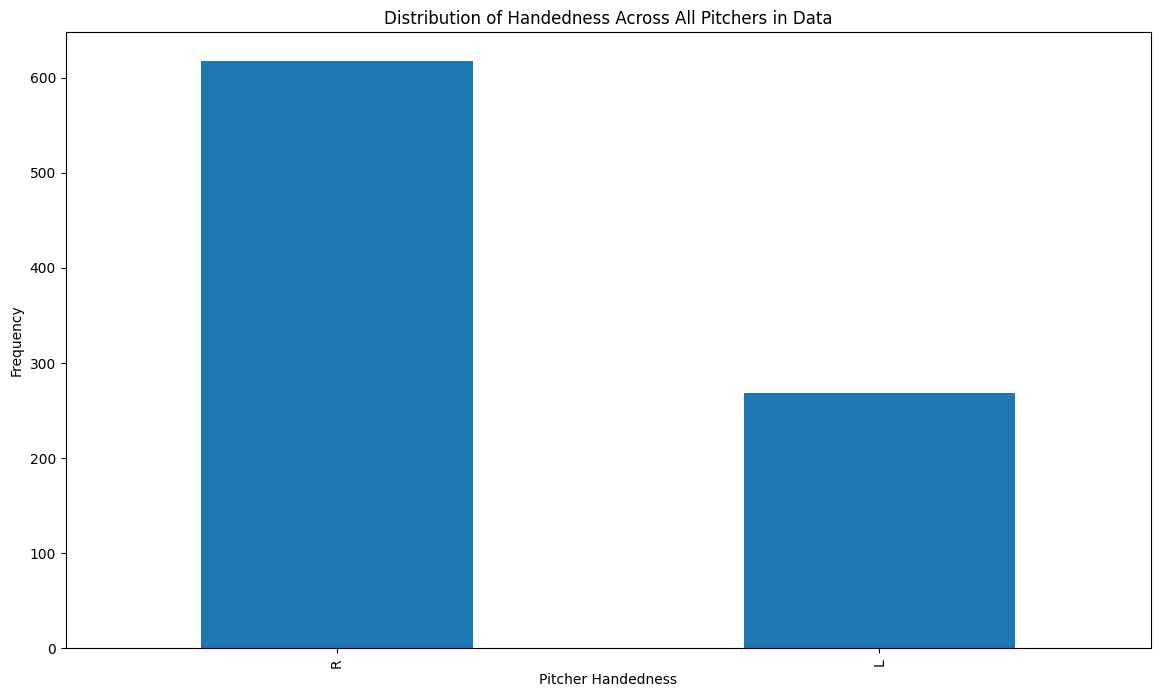

In [21]:
ax = df_pitcher_hand['hand'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Handedness Across All Pitchers in Data")
ax.set_xlabel("Pitcher Handedness")
ax.set_ylabel("Frequency")
plt.show()

# Batter Handedness

In [22]:
with db.connect("../database/smt_2025.db") as con:
    df_batters = con.sql("""SELECT DISTINCT batter FROM game_info""").df()
    df_batter_hand = con.sql("""WITH bh AS 
                         (SELECT * FROM
                         (SELECT field_x, play_id, game_str,
                         DENSE_RANK() OVER (PARTITION BY game_str, play_id ORDER BY timestamp) AS rank
                         FROM player_pos pp
                         WHERE player_position = 10) AS subquery
                         WHERE rank = 1),
                             
                         batter_rp AS (
                         SELECT bh.game_str, bh.field_x, batter 
                         FROM bh
                         LEFT JOIN game_info gi
                         ON bh.game_str = gi.game_str AND bh.play_id = gi.play_per_game)
                             
                         SELECT AVG(field_x) avg_stance, batter FROM batter_rp
                         GROUP BY batter""").df()
    
    

df_batter_hand["hand"] = np.where(df_batter_hand["avg_stance"] > 0, "L", "R")
df_batter_hand


,avg_stance,batter,hand
0,1.150527,RZQ-0310,L
1,-1.214769,POW-1650,R
2,2.930058,KIR-2215,L
3,-2.732157,KIR-1912,R
4,2.550424,KIR-1886,L
...,...,...,...
1034,0.617612,DMS-1813,L
1035,-3.152800,YJD-0224,R
1036,-3.234900,STK-1675,R
1037,2.439150,RZQ-0221,L


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.


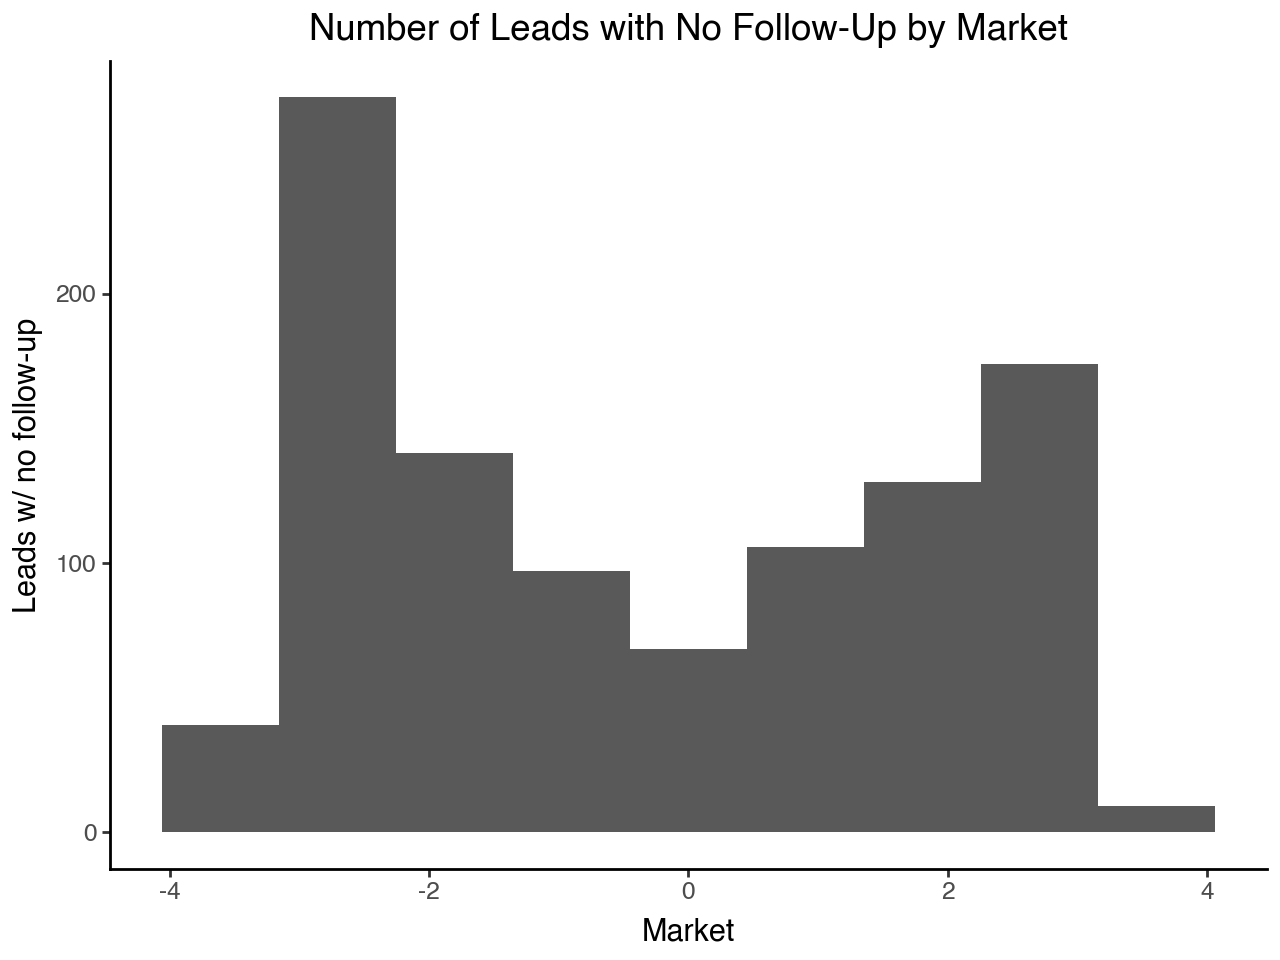

In [15]:
ggplot(df_batter_hand, aes(x='avg_stance')) \
+ geom_histogram() \
+ labs(title = "Number of Leads with No Follow-Up by Market",
       x="Market",
       y="Leads w/ no follow-up") \
+ theme_classic()

In [16]:
ax = df_batter_hand['hand'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Distribution of Handedness Across All Batters in Data")
ax.set_xlabel("Batter Handedness")
ax.set_ylabel("Frequency")

Text(0, 0.5, 'Frequency')

# Runs

In [47]:
with db.connect("../database/smt_2025.db") as con:
    df_runs = con.sql("""
                      SELECT game_str, play_per_game, first_baserunner, second_baserunner, third_baserunner,
                      prev_first, prev_second, prev_third
                      FROM 
                      (SELECT *, LAG(first_baserunner) OVER (ORDER BY play_per_game, top_bottom_inning) AS prev_first ,
                      LAG(second_baserunner) OVER (ORDER BY play_per_game, top_bottom_inning) AS prev_second,
                      LAG(third_baserunner) OVER (ORDER BY play_per_game, top_bottom_inning) AS prev_third 
                      FROM game_info) subquery
                      WHERE (prev_first != first_baserunner AND prev_first != second_baserunner AND prev_first != third_baserunner)
                      OR (prev_second != second_baserunner AND prev_second != third_baserunner)
                      OR (prev_third != third_baserunner)
                      """).df()
    df_runs_per_play = con.sql(""" 
                      SELECT play_id, game_str, SUM(run) As runs FROM
                      (SELECT DISTINCT play_id, game_str, 
                      CASE 
                        WHEN (player_position = 11 AND abs(field_x) < 1 AND abs(field_y) < 1) THEN 1 
                        ELSE 0
                      END AS run
                      FROM player_pos
                      UNION ALL
                      SELECT DISTINCT play_id, game_str, 
                      CASE 
                        WHEN (player_position = 12 AND abs(field_x) < 1 AND abs(field_y) < 1) THEN 1 
                        ELSE 0
                      END AS run
                      FROM player_pos
                      UNION ALL
                      SELECT DISTINCT play_id, game_str, 
                      CASE 
                        WHEN (player_position = 13 AND abs(field_x) < 1 AND abs(field_y) < 1) THEN 1 
                        ELSE 0
                      END AS run
                      FROM player_pos) subquery
                      GROUP BY game_str, play_id""").df()
    
df_runs_per_play[df_runs_per_play["runs"] > 0]

,play_id,game_str,runs
30,16,y1_d096_XAX_QEA,1.0
36,59,y1_d011_DYE_RZQ,1.0
250,206,y1_d022_AKX_YJD,1.0
258,259,y2_d072_DYE_YJD,1.0
269,287,y2_d004_GHD_YJD,1.0
...,...,...,...
79424,245,y1_d065_IAQ_YJD,1.0
79428,123,y1_d066_IAQ_YJD,1.0
79612,229,y1_d071_ACN_QEA,1.0
79629,296,y1_d057_OXG_QEA,1.0


In [56]:
with db.connect("../database/smt_2025.db") as con:
    df_play = con.sql("""SELECT * FROM ball_pos WHERE game_str = 'y1_d096_XAX_QEA' AND play_id = 16""").df()

df_play

,game_str,play_id,timestamp,ball_position_x,ball_position_y,ball_position_z,home_team,away_team,year,day
0,y1_d096_XAX_QEA,16,514008,-0.538644,53.35710,5.63712,QEA,XAX,year_1,day_096
1,y1_d096_XAX_QEA,16,514058,-0.329760,46.76550,5.55237,QEA,XAX,year_1,day_096
2,y1_d096_XAX_QEA,16,514108,-0.147075,40.18830,5.39262,QEA,XAX,year_1,day_096
3,y1_d096_XAX_QEA,16,514158,0.009410,33.62550,5.15787,QEA,XAX,year_1,day_096
4,y1_d096_XAX_QEA,16,514208,0.139694,27.07701,4.84809,QEA,XAX,year_1,day_096
...,...,...,...,...,...,...,...,...,...,...
118,y1_d096_XAX_QEA,16,521008,9.751260,25.29660,9.38268,QEA,XAX,year_1,day_096
119,y1_d096_XAX_QEA,16,521058,9.646590,21.25695,8.09196,QEA,XAX,year_1,day_096
120,y1_d096_XAX_QEA,16,521108,9.556740,17.26362,6.73896,QEA,XAX,year_1,day_096
121,y1_d096_XAX_QEA,16,521158,9.481680,13.31661,5.32371,QEA,XAX,year_1,day_096


In [24]:
df_runs_per_play[df_runs_per_play["runs"] == 3]

,play_id,game_str,runs
2511,114,y1_d050_JZK_RZQ,3.0
18157,21,y2_d033_KNB_YJD,3.0
20278,52,y1_d012_IXC_QEA,3.0
20860,57,y2_d036_UKI_RZQ,3.0
21799,92,y1_d007_MCJ_RZQ,3.0
30485,248,y1_d064_IAQ_YJD,3.0
38428,249,y1_d030_CMS_YJD,3.0
42766,55,y1_d096_WNA_RZQ,3.0
51905,108,y1_d001_CGA_QEA,3.0
67391,148,y2_d099_YJD_RZQ,3.0


# Outs

In [ ]:
with db.connect("../database/smt_2025.db") as con:
    df_missing_runners = con.sql("""SELECT *, LAG(first_baserunner) OVER ()""")

# Play Animation

In [58]:
import pandas as pd
from sportypy.surfaces import MiLBField
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from IPython.display import HTML

def plot_animation(player_position_df: pd.DataFrame, 
                   ball_position_df: pd.DataFrame, 
                   play_id: int = 1, 
                   save_gif: bool = False) -> HTML:
    
    """
    A function that plots field animations for a particular instance of a game.
    Example usage:
    
    ```
    player_pos = pd.read_parquet('./Combined/player_pos/1884_110_Vis2AR_Home2A.parquet')
    ball_pos = pd.read_parquet('./Combined/ball_pos/1884_110_Vis2AR_Home2A.parquet')
    
    plot_animation(player_pos, ball_pos, play_id = 30, save_gif = True)
    ```
    
    Params:
        player_position_df: A Data Frame for the player position coordinates on a field.
        ball_position_df: A Data Frame for the ball position coordiantes on a field.
        play_id: A integer field that denotes the play id you want to visualize. Defaults to 1.
        save_gif: A boolean that when set to true saves the animation to a gif. 
                  Defaults to not saving animation (False).
    
    Returns:
        HTML display of the animation. You can slow or speed up the fps with the + and - buttons.
        You can also press the > arrow to start the animation.
    """
    
    if not isinstance(play_id, int):
        raise ValueError("Play ID must be an Integer. This function only handles one Play ID.")
    
    if len(player_position_df['game_str'].unique()) > 1 or len(ball_position_df['game_str'].unique()) > 1:
        raise ValueError("Player Position or Ball Position Data Frame has multiple games. Please filter for one game at a time.")
    
    player_pos = player_position_df.query(f'play_id == {play_id}')
    ball_pos = ball_position_df.query(f'play_id == {play_id}')
    
    merged_df = pd.merge(player_pos, ball_pos, on = ['timestamp', 'play_id', 'game_str'], how = 'inner')
    merged_df = merged_df[merged_df['player_position'] < 14] # Elminate umpires and coaches on field
    
    field = MiLBField()
    field.draw(display_range='full')

    fig = plt.gcf()
    ax = plt.gca()

    p = field.scatter([], [], c='white')
    b = field.scatter([], [], c='red')

    game_id = merged_df['game_str'].unique()[0]
    game_text = ax.text(0, 400, f'Game ID: {game_id}', c='white', ha='center')
    play_text = ax.text(120, 0, f'Play: {play_id}', c='white', ha='center')


    def update(frame):
        frame_data = merged_df[merged_df['timestamp'] <= frame]

        players = frame_data.sort_values('timestamp').drop_duplicates(subset=['player_position'], keep='last')
        balls = frame_data[['ball_position_x', 'ball_position_y', 'ball_position_z']].dropna().iloc[-1:]

        players_colors = ['yellow' if 10 <= pos <= 13 else 'white' for pos in players['player_position']]

        p.set_offsets(np.c_[players['field_x'], players['field_y']])
        p.set_color(players_colors)

        ball_size = (balls['ball_position_z'].values * 8)
        b.set_offsets(np.c_[balls['ball_position_x'], balls['ball_position_y']])
        
        if ball_size < 1:
             ball_size = np.array([10])
                

        return p, b

    ani = FuncAnimation(fig, update, frames=np.linspace(merged_df['timestamp'].min(), 
                                                        merged_df['timestamp'].max(), num=50), blit=True)

    if save_gif:
        ani.save('animation.gif', writer='imagemagick', fps=10)
    
    return HTML(ani.to_jshtml())

In [59]:
with db.connect("../database/smt_2025.db") as con:

    player_position_df = con.sql("""SELECT * FROM player_pos  
                                    WHERE game_str = 'y2_d072_DYE_YJD'; """).df()
    ball_position_df = con.sql("""SELECT * FROM ball_pos  
                                    WHERE game_str = 'y2_d072_DYE_YJD'; """).df()

# Animate play
# Arguments are player_pos, ball_pos, play_id, and whether we want to save the animation afterwards
plot_animation(player_position_df, ball_position_df, 259, False)

In [29]:
from backend.animation.Animation import plot_animation
def random_play(df):
    random_row = df.sample(n=1).reset_index(drop=True)
    try:
        with db.connect("../database/smt_2025.db") as con:
                game_string = random_row["game_str"].iloc[0]
                print(game_string)
                play_id = random_row["play_per_game"].iloc[0]
                player_position_df = con.sql(f"""SELECT * FROM player_pos  
                                                WHERE game_str = '{game_string}';""").df()
                ball_position_df = con.sql(f"""SELECT * FROM ball_pos  
                                                WHERE game_str = '{game_string}';""").df()
                plot_animation(player_position_df, ball_position_df, int(play_id), True)
                return
    except: 
        random_play(df)

y2_d033_KNB_YJD
y1_d034_AVV_YJD


MovieWriter imagemagick unavailable; using Pillow instead.


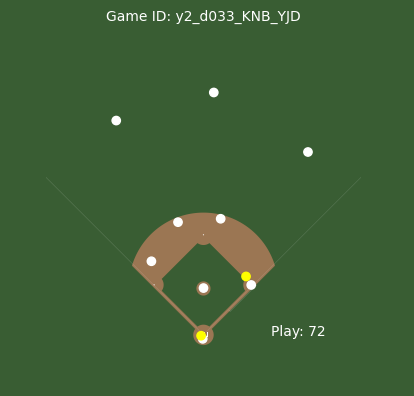

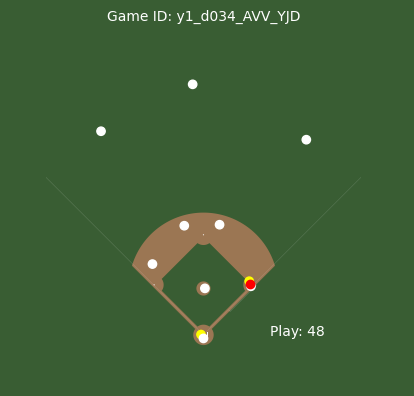

In [30]:
df_pick = pd.read_csv("../database/pickoff_plays.csv")
random_play(df_pick)